In [7]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Set-up

In [8]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]
print (deptht.shape)

(40,)


## Month

In [47]:
month = 'aug'
imonth = '08'

In [10]:
years = ['2018', '2017', '2016', '2015']

# Functions

In [11]:
def surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, twoD=False):
    fig, axs = plt.subplots(2, 7, figsize=(20, 10))

    dm = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_'+month+'_climate_2015_2019_'+file+'_T.nc')
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, 0], mask=1-tmask[0, 0])
    colours = axs[0, 0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0, 0].set_title('Nowcast Climatology')
    fig.colorbar(colours, ax=axs[0, 0])

    for iix, year in enumerate(years):
        ix = iix + 2
        ym = year + imonth
        ds = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_1m_'+ym+'_'+ym+'_'+file+'_T.nc')
        if twoD:
            field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
        else:
            field = np.ma.array(ds[tracer][0, 0], mask=1-tmask[0,0])
        colours = axs[0, ix].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
        axs[0, ix].set_title(year)
        fig.colorbar(colours, ax=axs[0, ix])
    
        colours = axs[1, ix].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
        fig.colorbar(colours, ax=axs[1, ix])
        ds.close()

    year = '2013'
    ym = year + imonth
    dn = xr.open_dataset('/results/SalishSea/averages/spinup.201905/SalishSea_1m_'+ym+'_'+ym+'_'+file+'_T.nc')
    if twoD:
        field = np.ma.array(dn[tracer][0], mask=1-tmask[0,0])
    else:
        field = np.ma.array(dn[tracer][0, 0], mask=1-tmask[0,0])
    colours = axs[0, -1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0, -1].set_title('Spin-up '+year)
    fig.colorbar(colours, ax=axs[0, -1])
    
    colours = axs[1, -1].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    fig.colorbar(colours, ax=axs[1, -1])
    dn.close()

    for ax in axs[0]:
        viz_tools.set_aspect(ax)
    for ax in axs[1]:
        viz_tools.set_aspect(ax)
    
    dm.close()
    return fig

In [12]:
def profiles(tracer, file):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    dm = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_'+month+'_climate_2015_2019_'+file+'_T.nc')
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Mean')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Mean')

    for iix, year in enumerate(years):
        ix = iix + 1
        ym = year + imonth
        ds = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_1m_'+ym+'_'+ym+'_'+file+'_T.nc')
        field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
        axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label=year)
    
        axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label=year)
        ds.close()

    year = '2013'
    ym = year + imonth
    dn = xr.open_dataset('/results/SalishSea/averages/spinup.201905/SalishSea_1m_'+ym+'_'+ym+'_'+file+'_T.nc')
    field = np.ma.array(dn[tracer][0], mask=1-tmask[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, '--', label='Spin-up')
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, '--', label='Spin-up')
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    dn.close()
   
    dm.close()
    return fig

In [13]:
def thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax):
    fig, axs = plt.subplots(7, 2, figsize=(15, 20))

    dm = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_'+month+'_climate_2015_2019_'+file+'_T.nc')
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0, 0], mean_field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0, 0].set_title('Nowcast Climatology')

    for iix, year in enumerate(years):
        ix = iix + 2
        ym = year + imonth
        ds = xr.open_dataset('/results/SalishSea/averages/nowcast-green.201812/SalishSea_1m_'+ym+'_'+ym+'_'+file+'_T.nc')
        field = np.array(ds[tracer][0])
        colours = vis.contour_thalweg(axs[ix, 0], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

        axs[ix, 0].set_title(year)
        colours = vis.contour_thalweg(axs[ix, 1], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
        ds.close()

    year = '2013'
    ym = year + imonth
    dn = xr.open_dataset('/results/SalishSea/averages/spinup.201905/SalishSea_1m_'+ym+'_'+ym+'_'+file+'_T.nc')
    field = np.array(dn[tracer][0])
    colours = vis.contour_thalweg(axs[-1, 0], field, bathy, mesh, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[-1, 0].set_title('Spin-up '+year)
    colours = vis.contour_thalweg(axs[-1, 1], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                  cmap=cdiff)

    dn.close()
    
    dm.close()
    fig.tight_layout()
    return fig

# Surface Plots

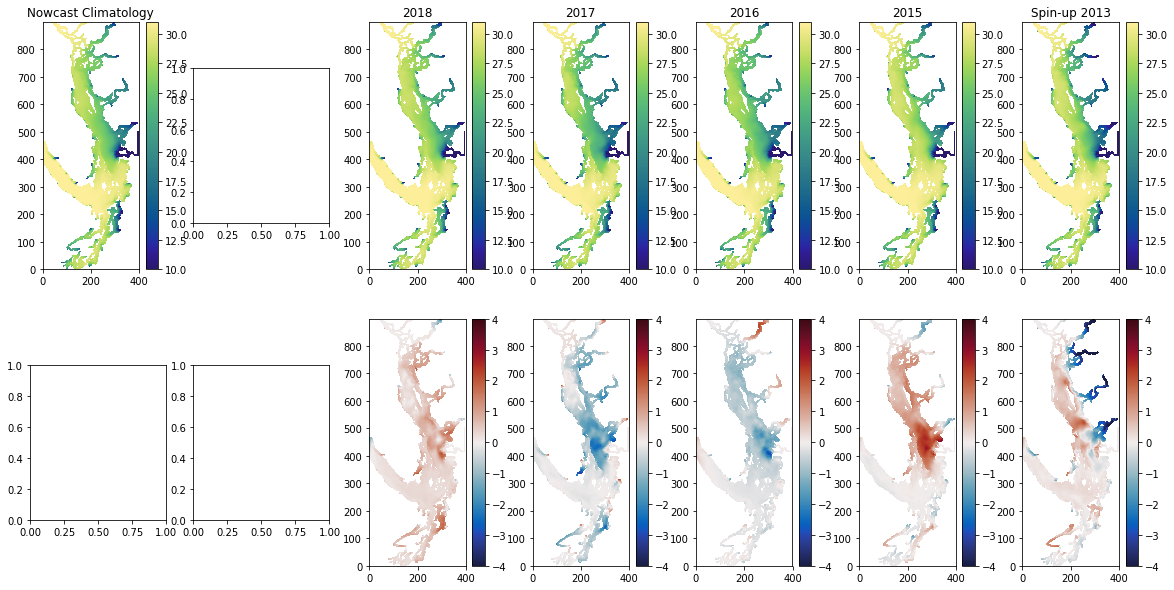

In [15]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 31
vmin = 10
dvmax = 4
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

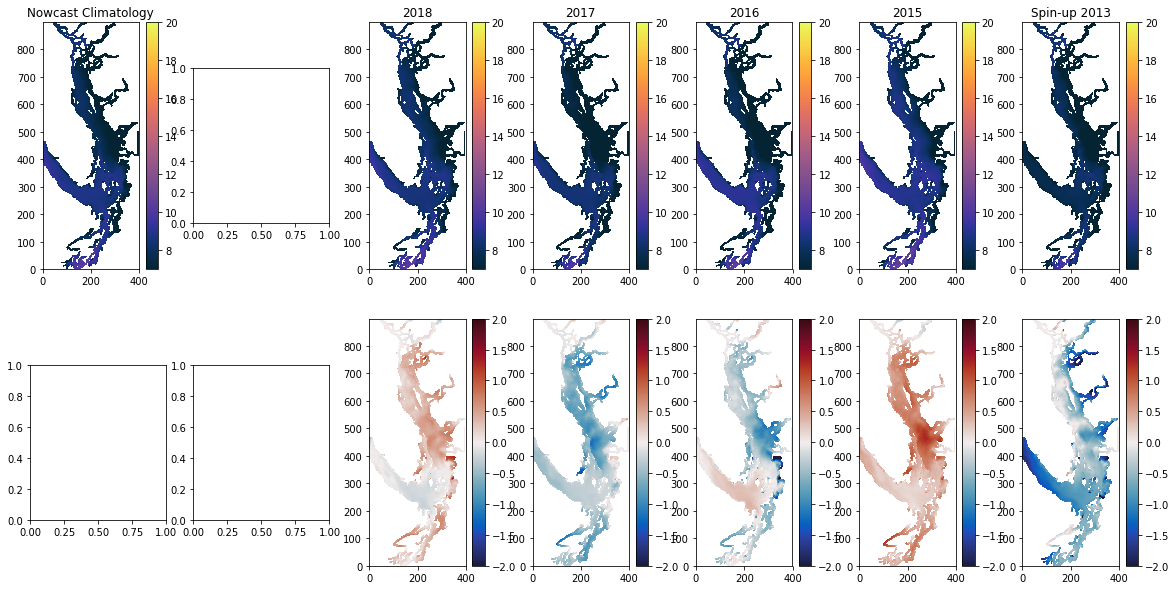

In [16]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cdiff = cm.balance
vmax = 20
vmin = 7
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

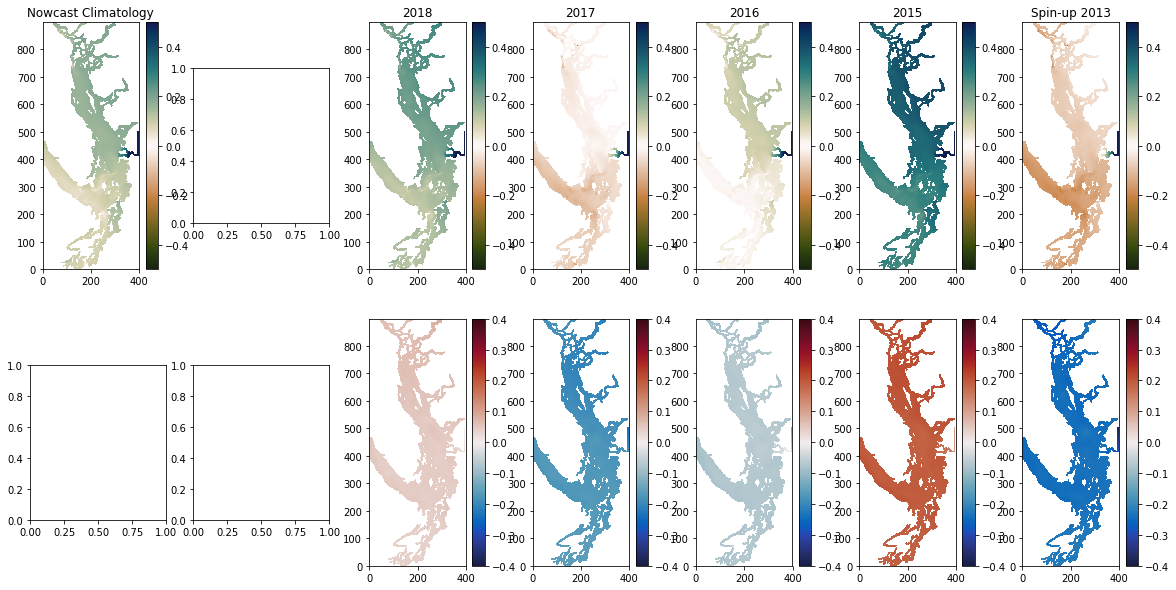

In [17]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.4
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, twoD=True)
fig.savefig(tracer+'_'+month+'_surface.png')

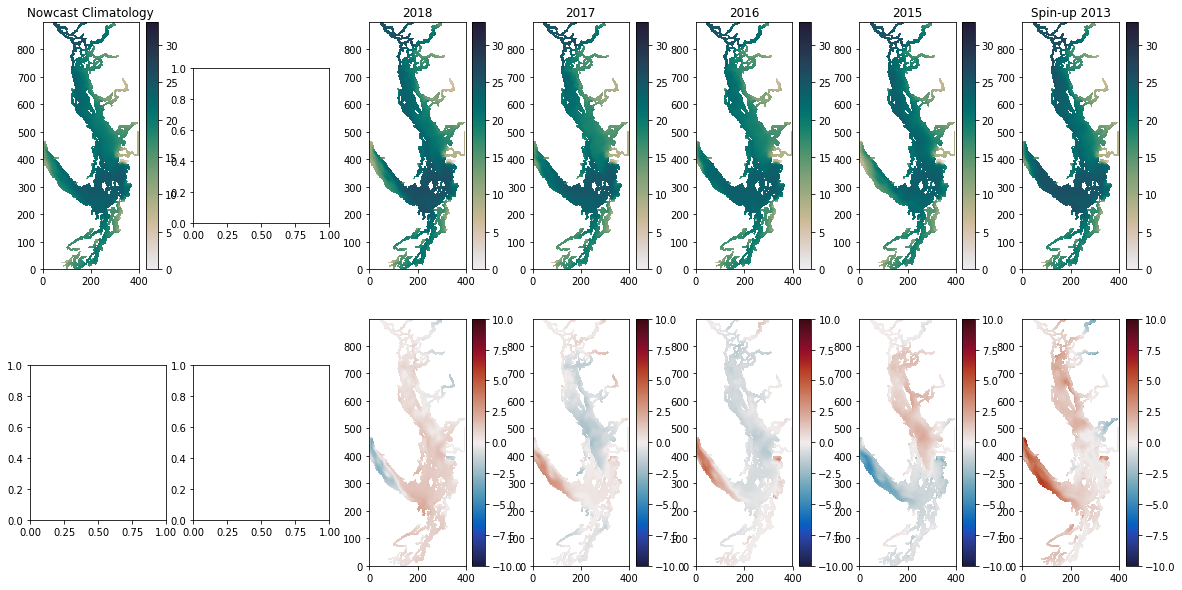

In [18]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 33
vmin = 0
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

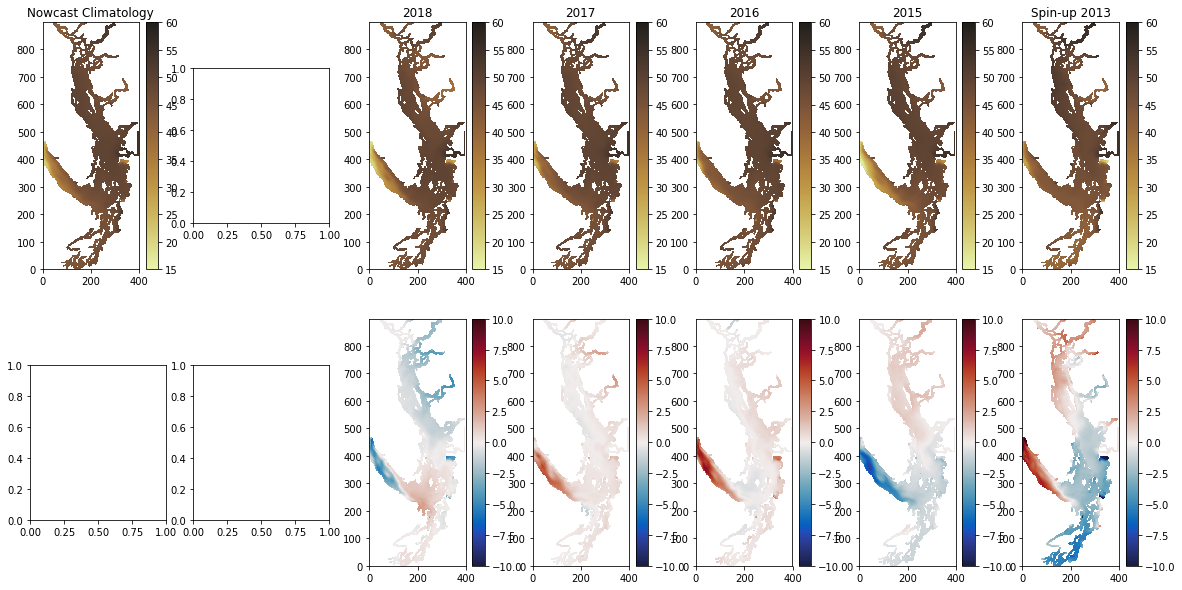

In [19]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 15
dvmax = 10
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

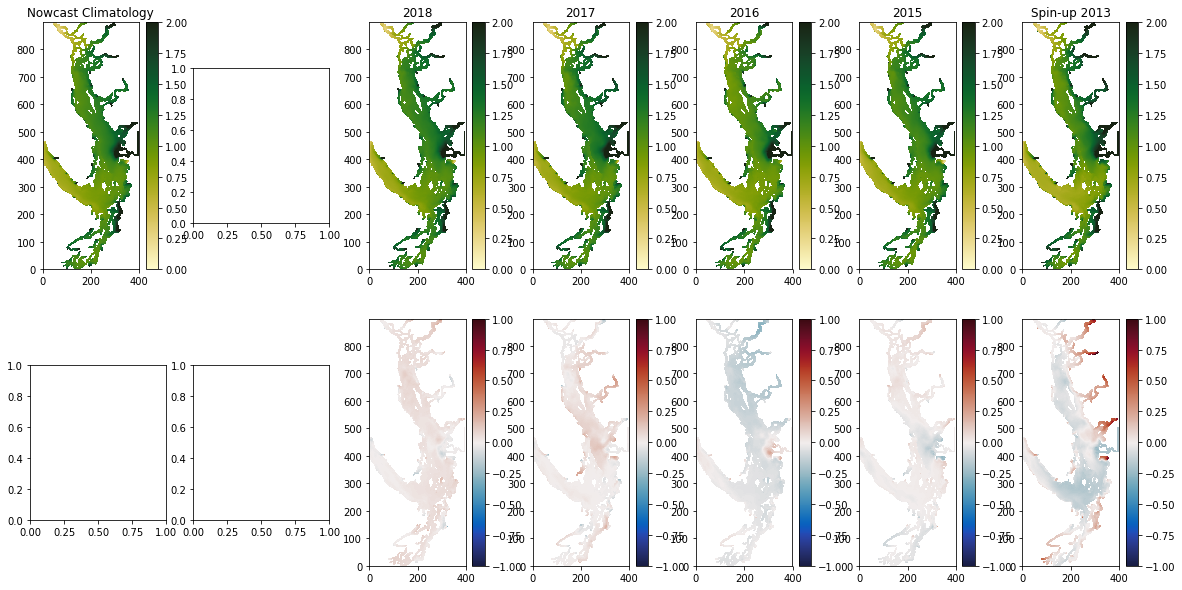

In [20]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

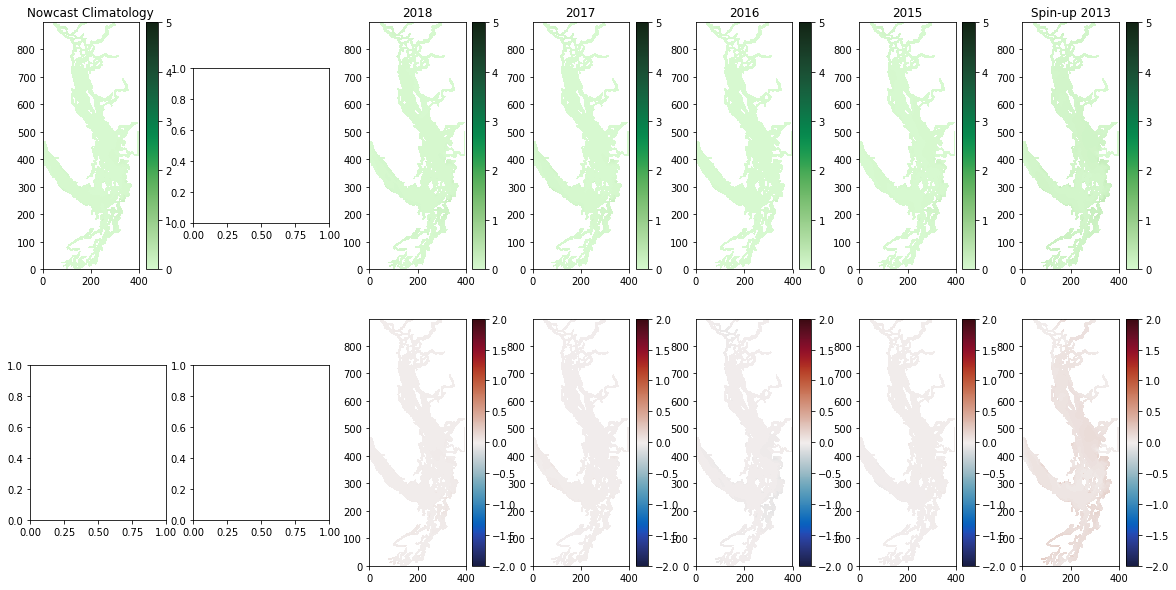

In [21]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

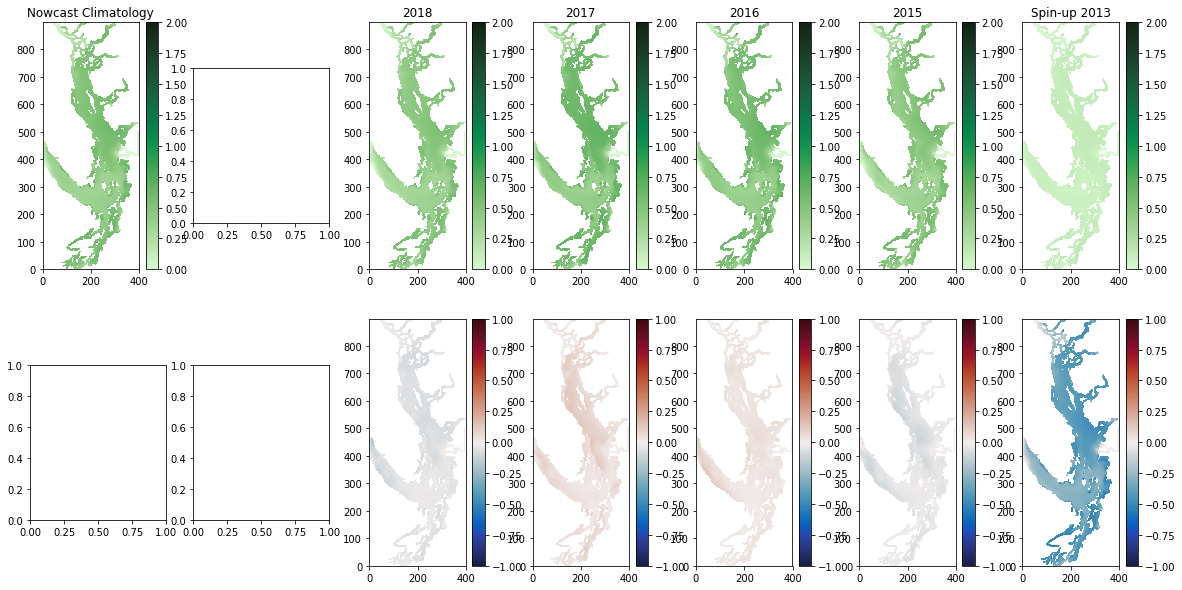

In [22]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

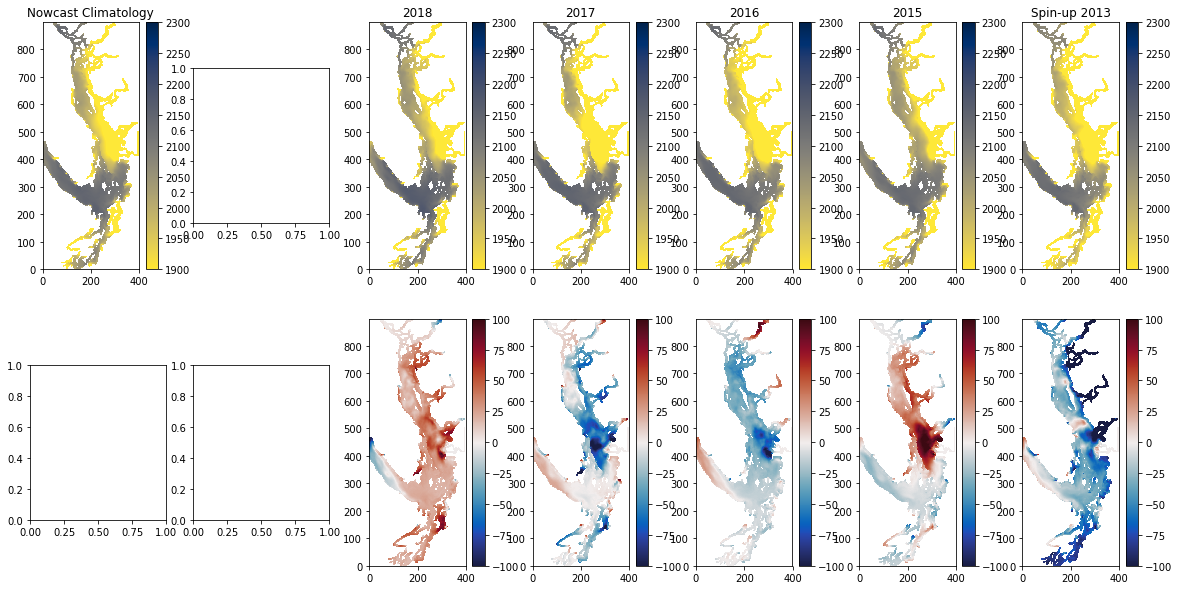

In [23]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 100
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

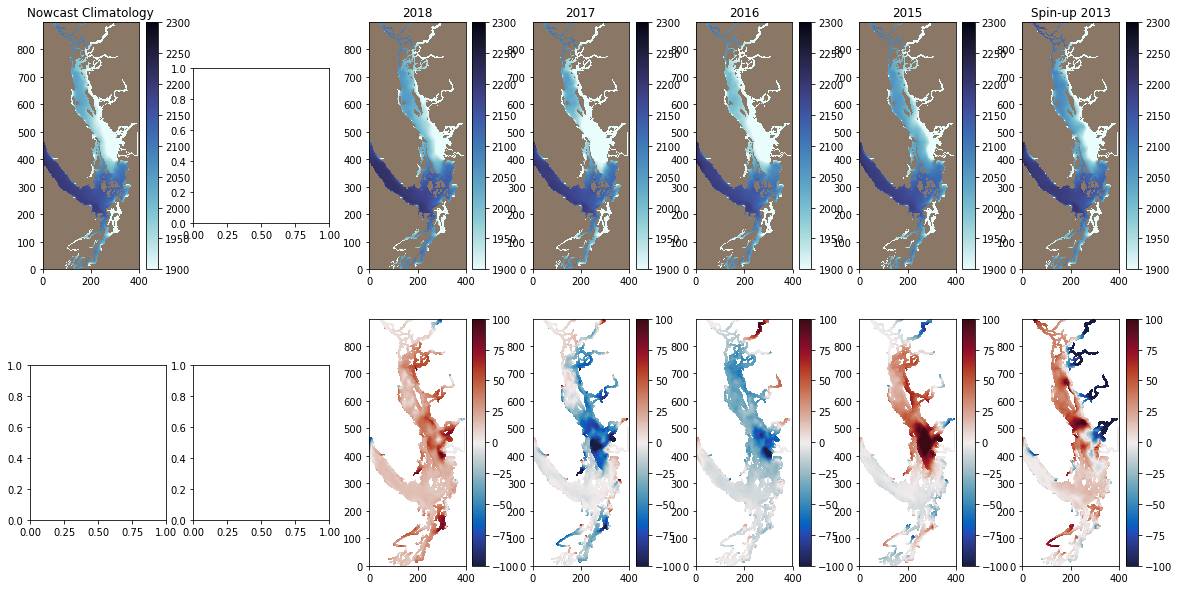

In [24]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 100
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

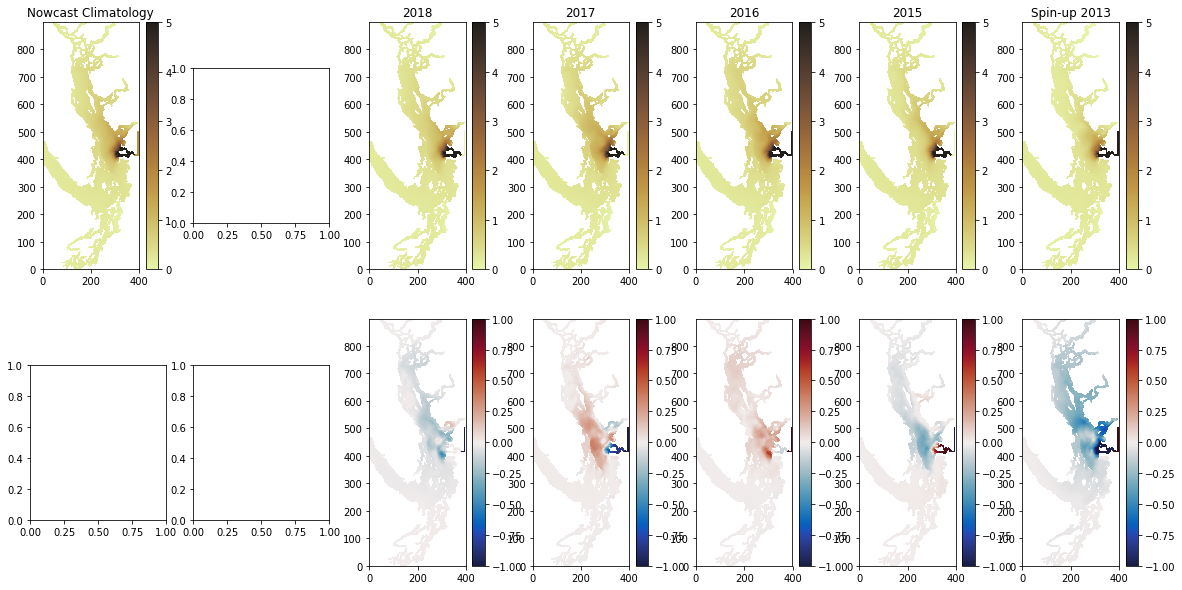

In [25]:
tracer = 'Fraser_tracer'
file = 'turb'
cmap = cm.turbid
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 1
fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_surface.png')

# Profiles

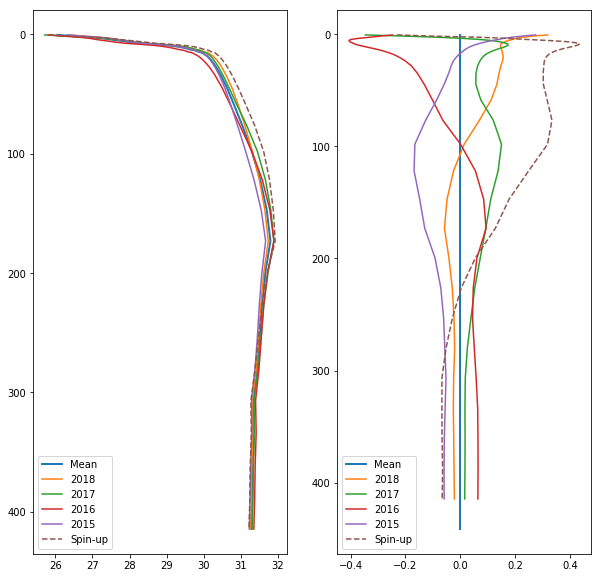

In [26]:
tracer = 'vosaline'
file = 'grid'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

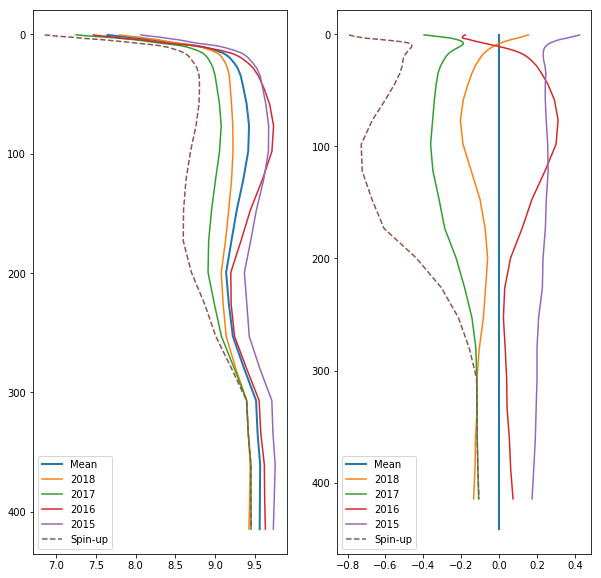

In [27]:
tracer = 'votemper'
file = 'grid'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

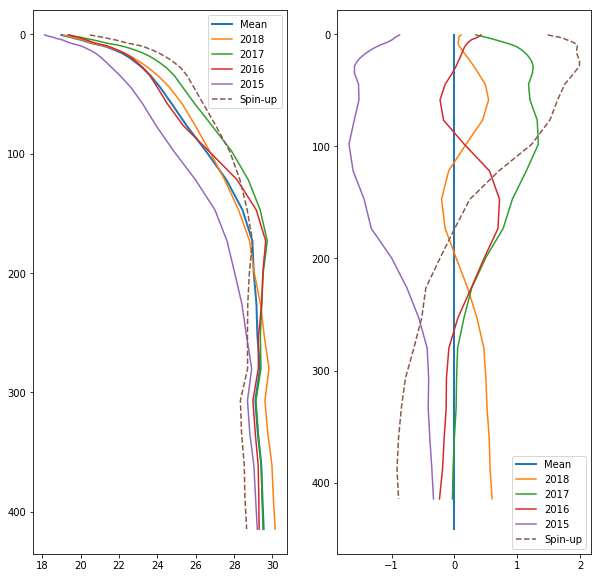

In [28]:
tracer = 'nitrate'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

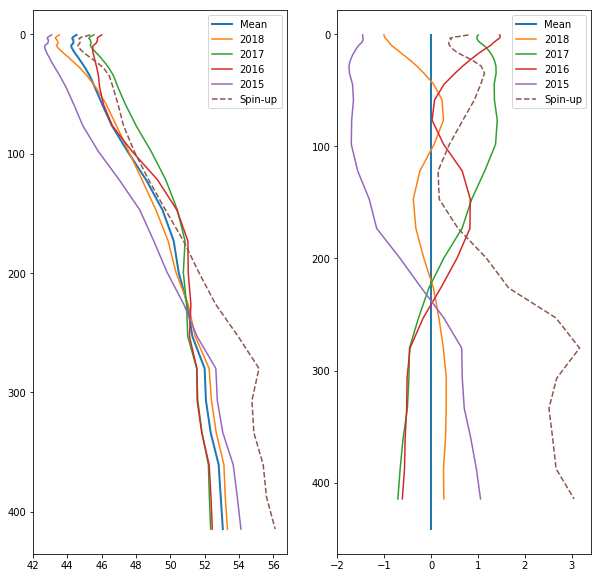

In [29]:
tracer = 'silicon'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

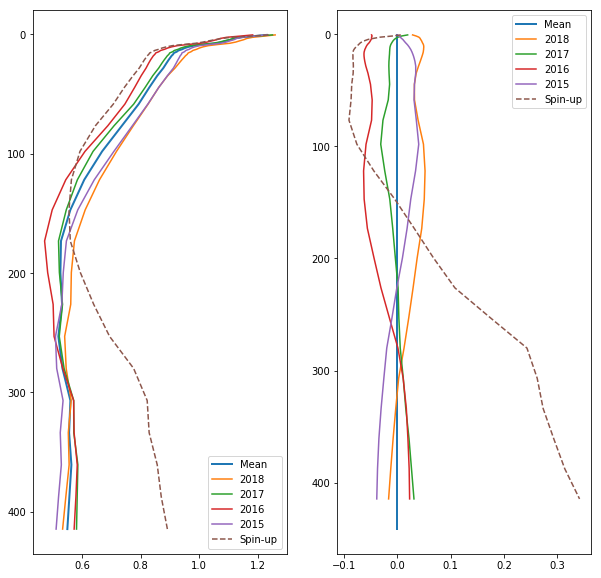

In [30]:
tracer = 'ammonium'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

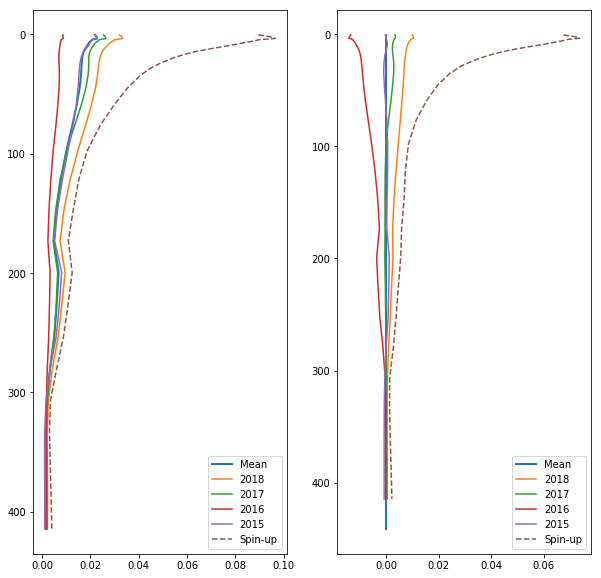

In [31]:
tracer = 'diatoms'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

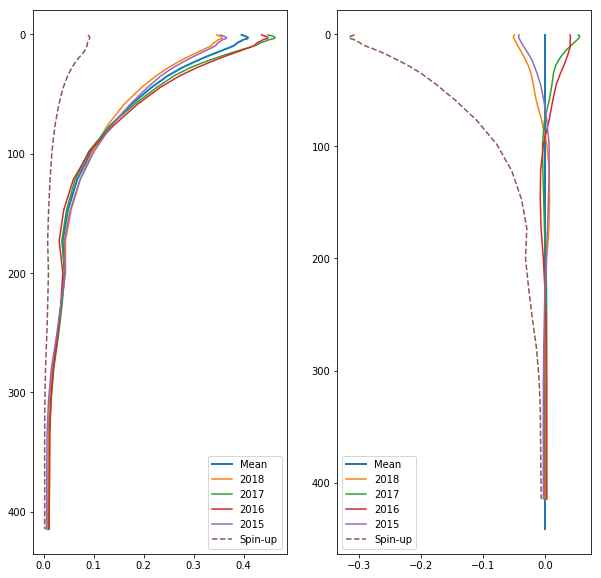

In [32]:
tracer = 'flagellates'
file = 'ptrc'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

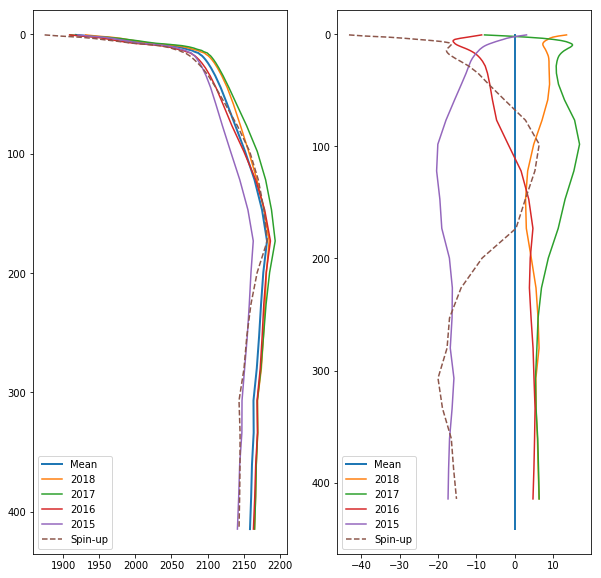

In [33]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

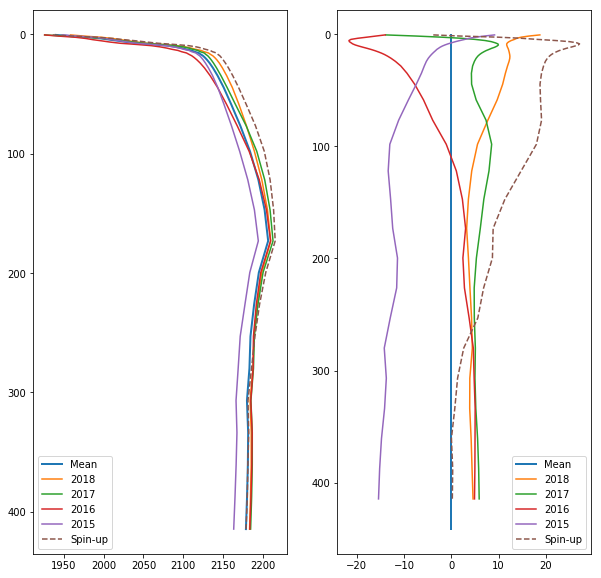

In [34]:
tracer = 'total_alkalinity'
file = 'carp'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

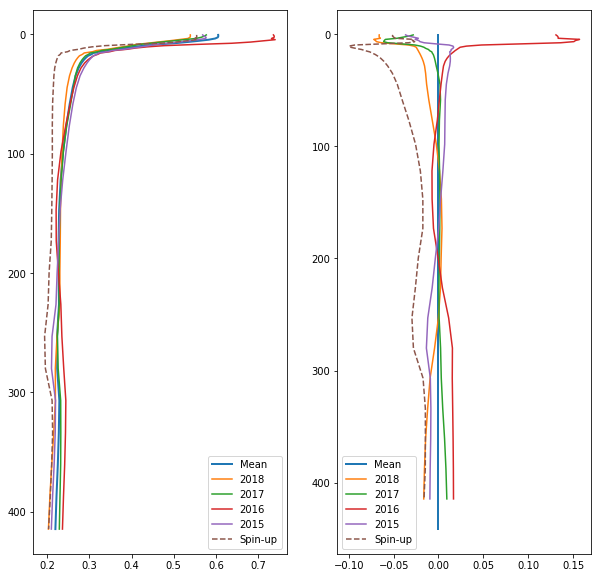

In [35]:
tracer = 'Fraser_tracer'
file = 'turb'
fig = profiles(tracer, file)
fig.savefig(tracer+'_'+month+'_profiles.png')

# Thalwegs

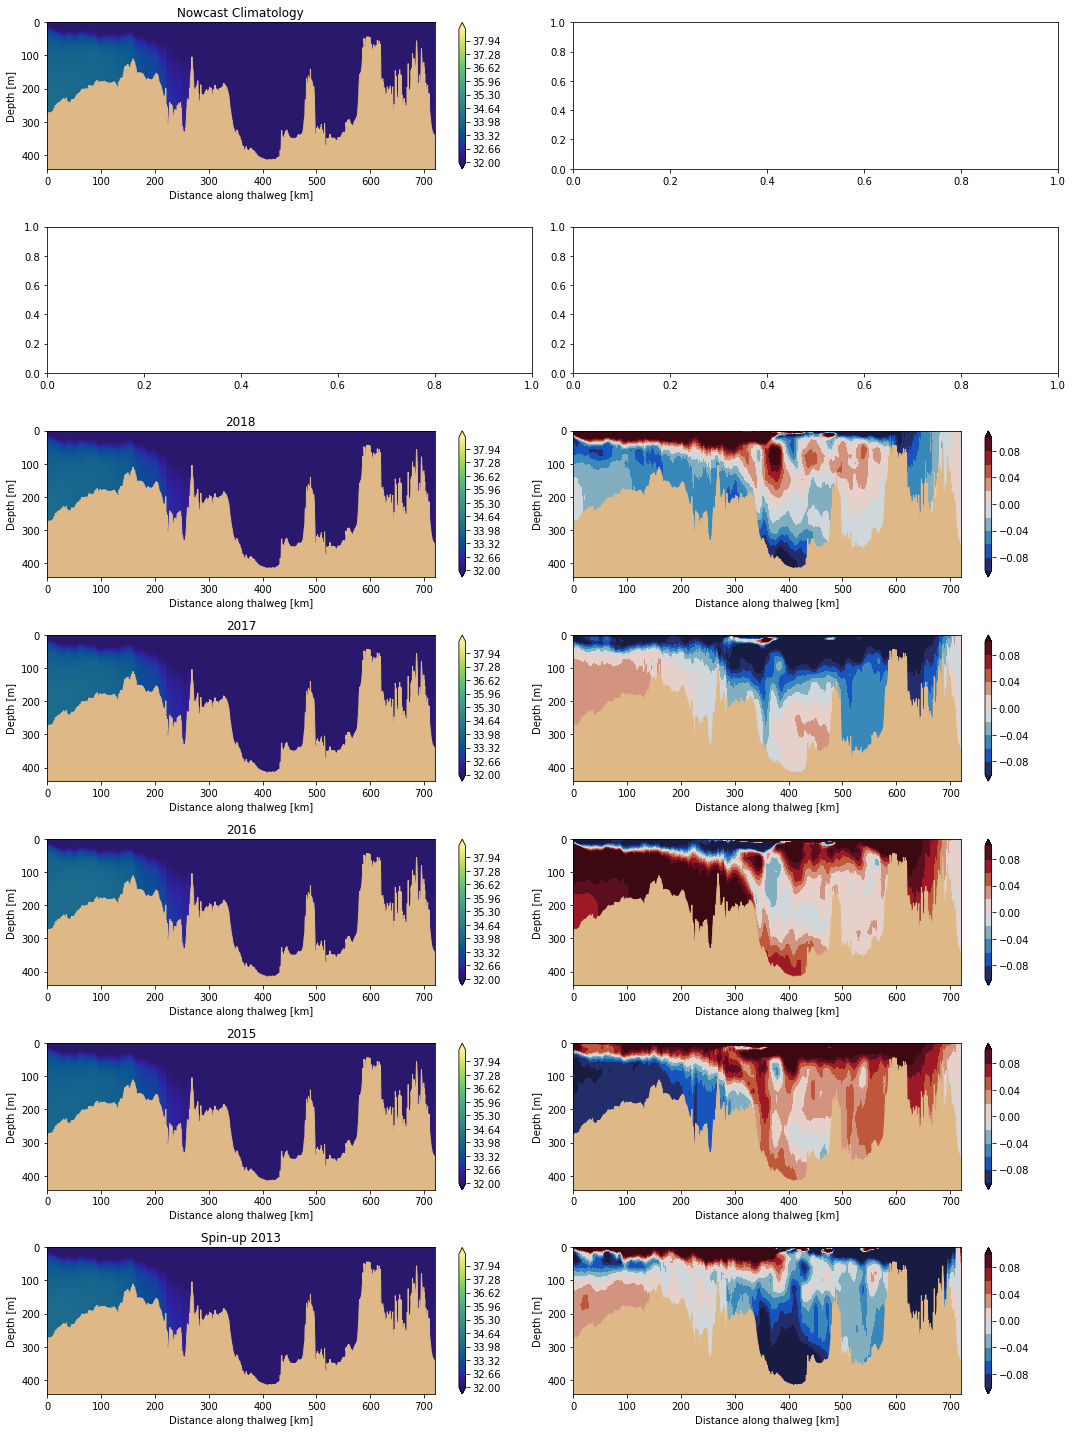

In [56]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32.1
vmin = 32
dvmax = 0.1
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
#fig.savefig(tracer+'_'+month+'_thalweg.png')

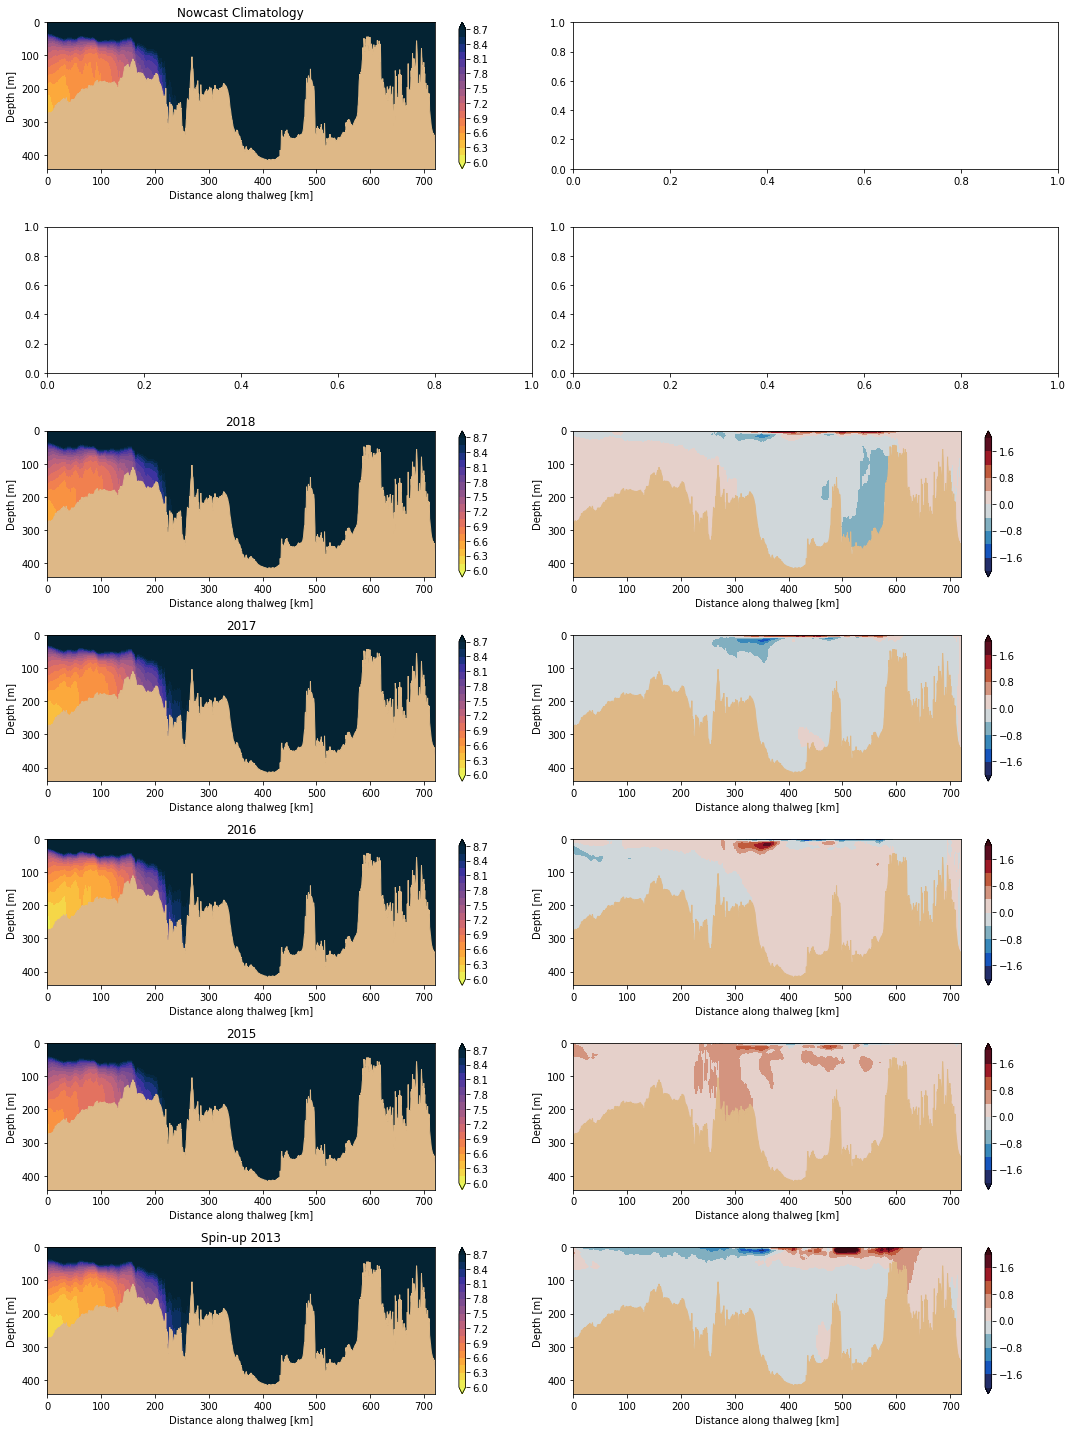

In [50]:
tracer = 'votemper'
file = 'grid'
cmap = cm.thermal
cdiff = cm.balance
vmax = 15
vmin = 6
dvmax = 2
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

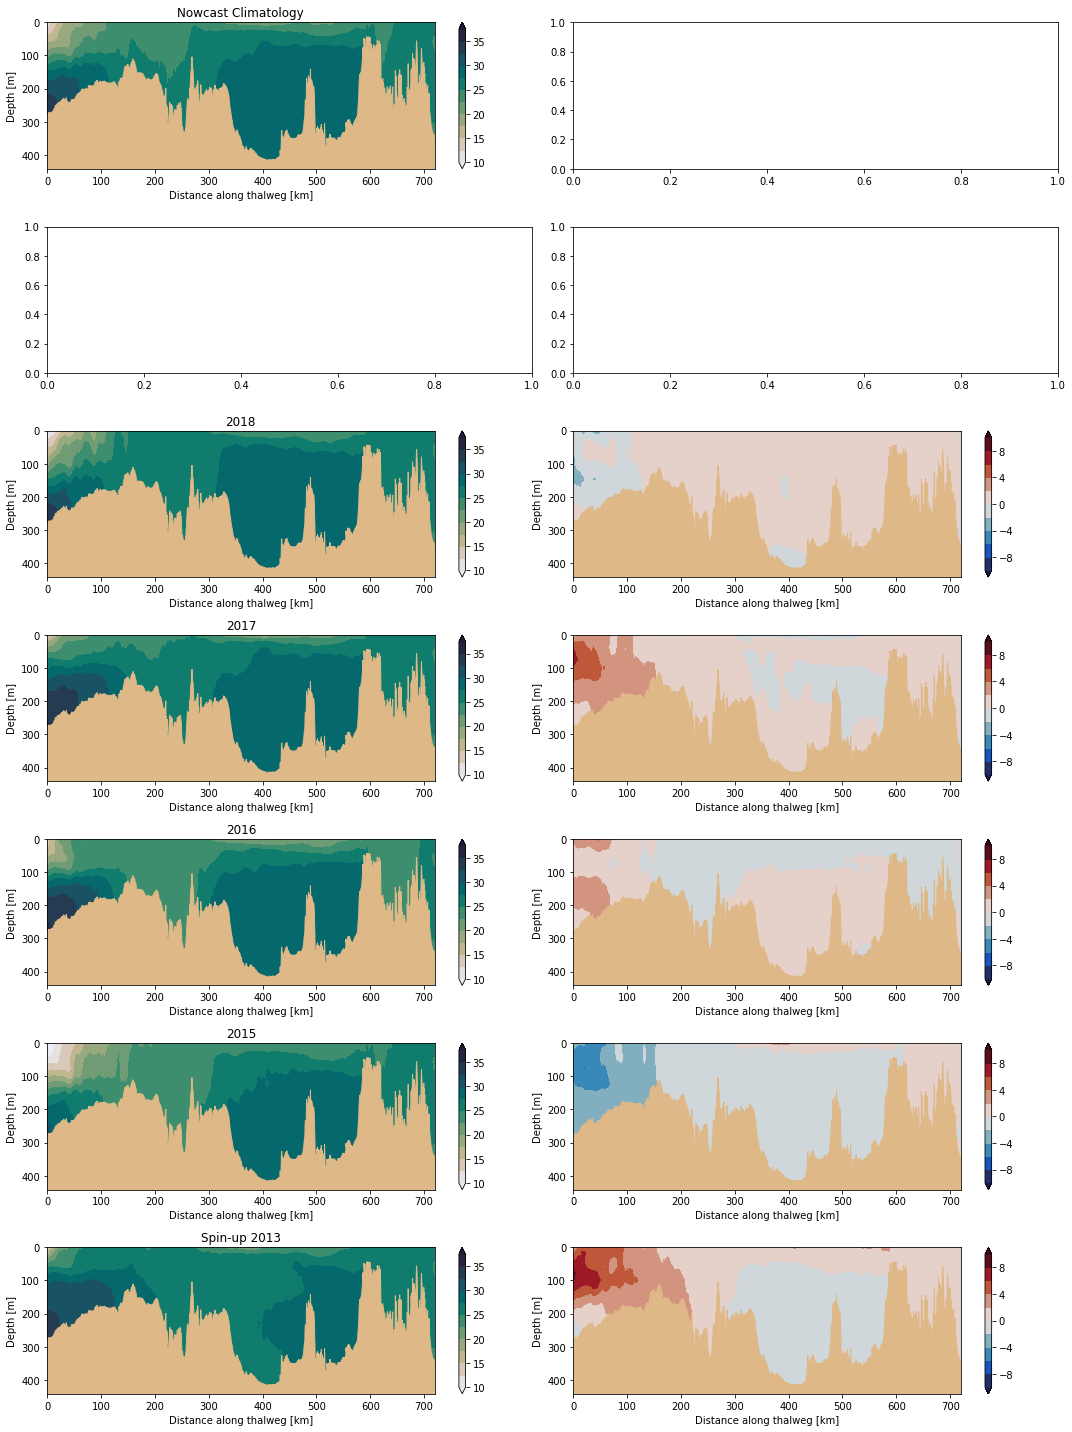

In [38]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 35
vmin = 10
dvmax = 10
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

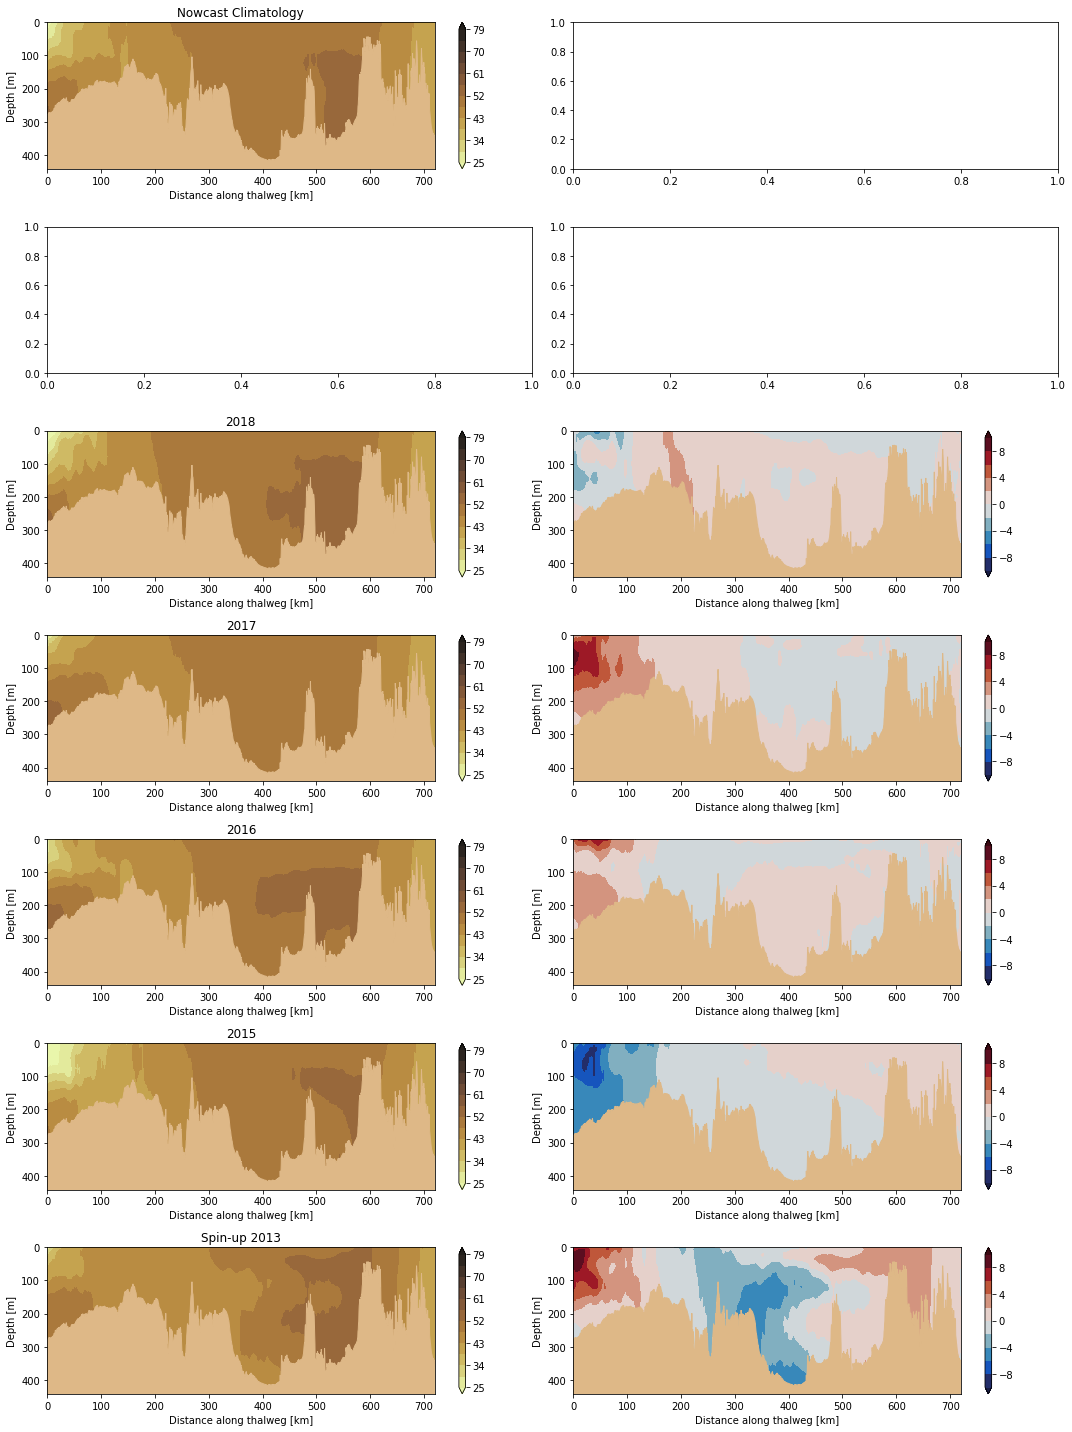

In [39]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 70
vmin = 25
dvmax = 10
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

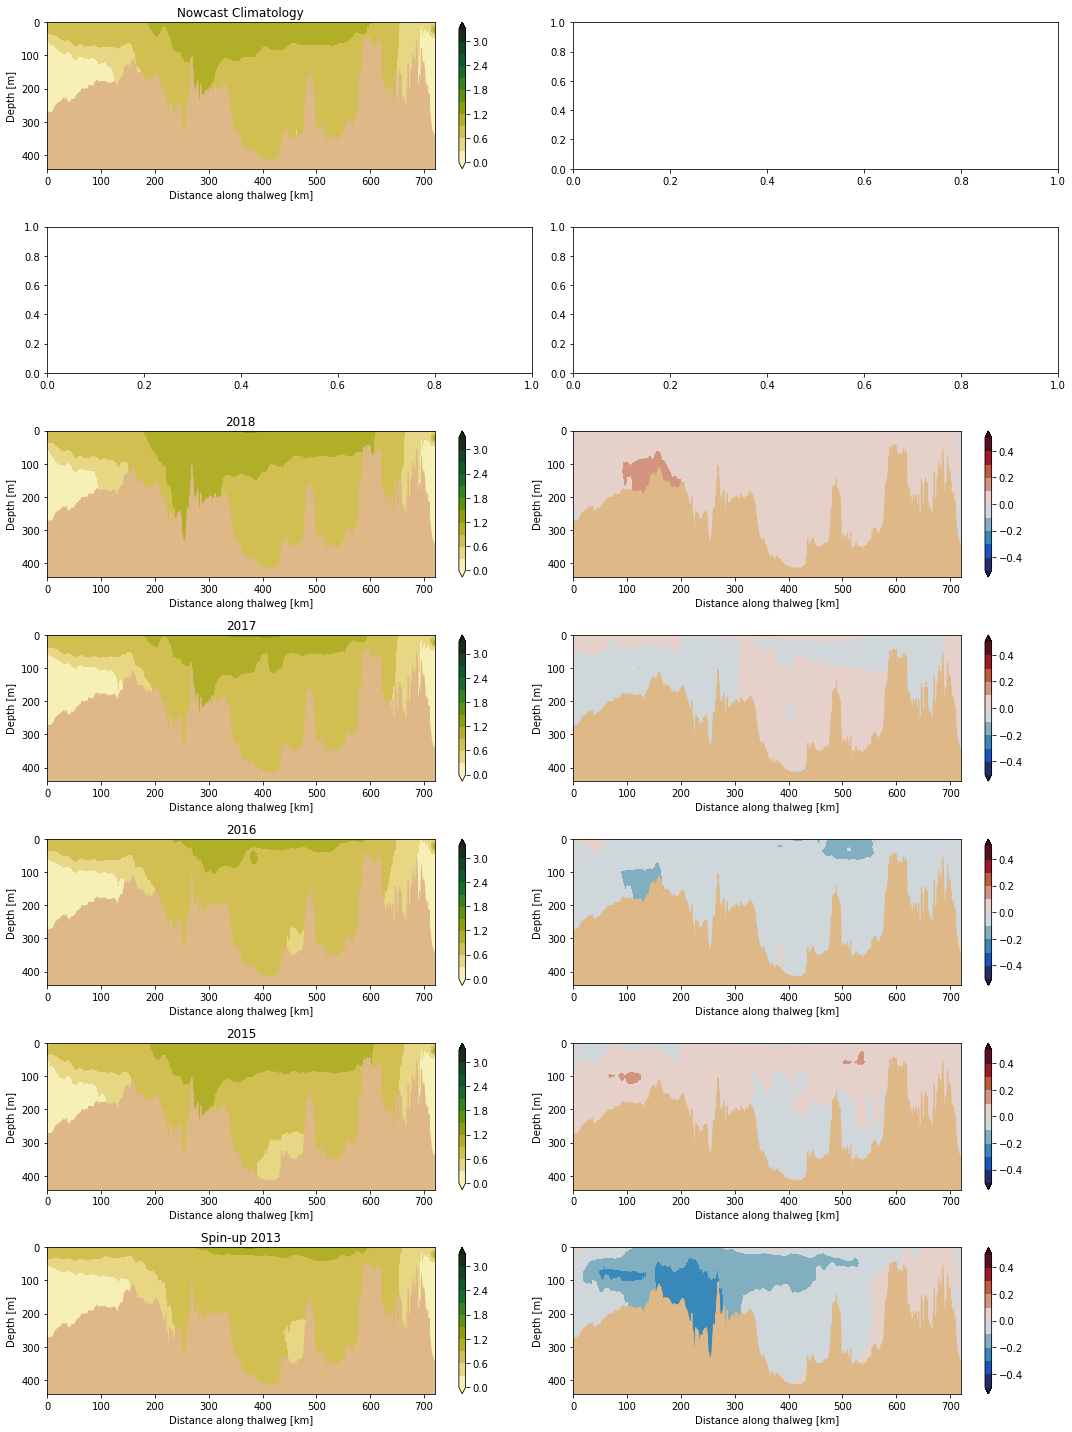

In [40]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 3
vmin = 0
dvmax = 0.5
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

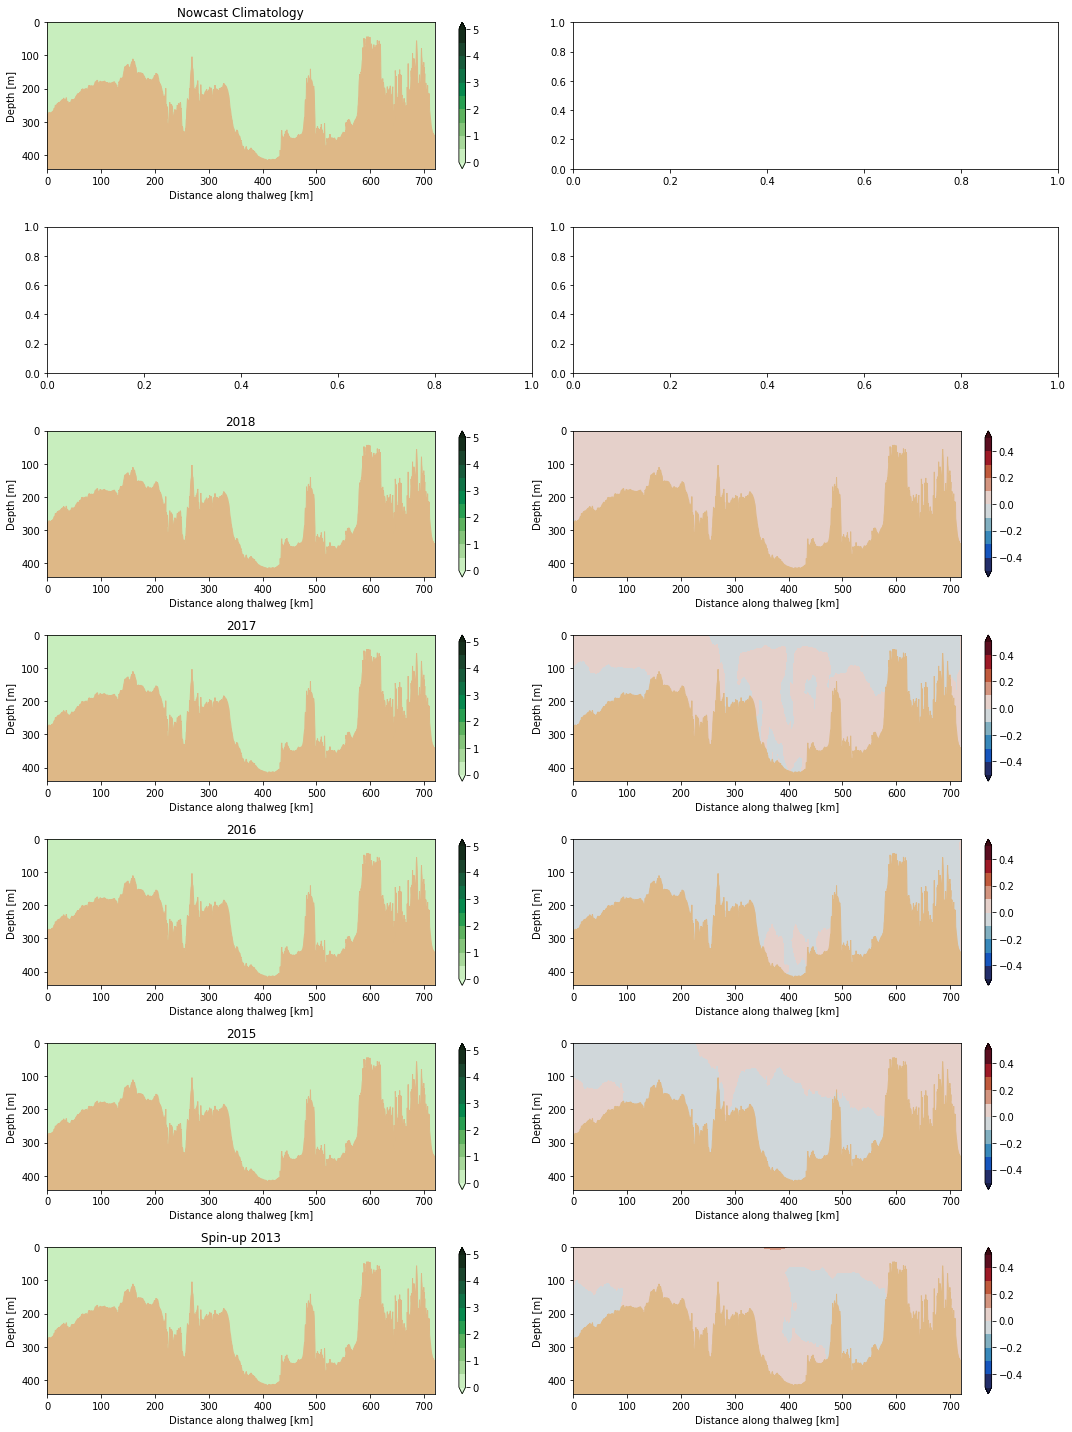

In [41]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 0.5
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

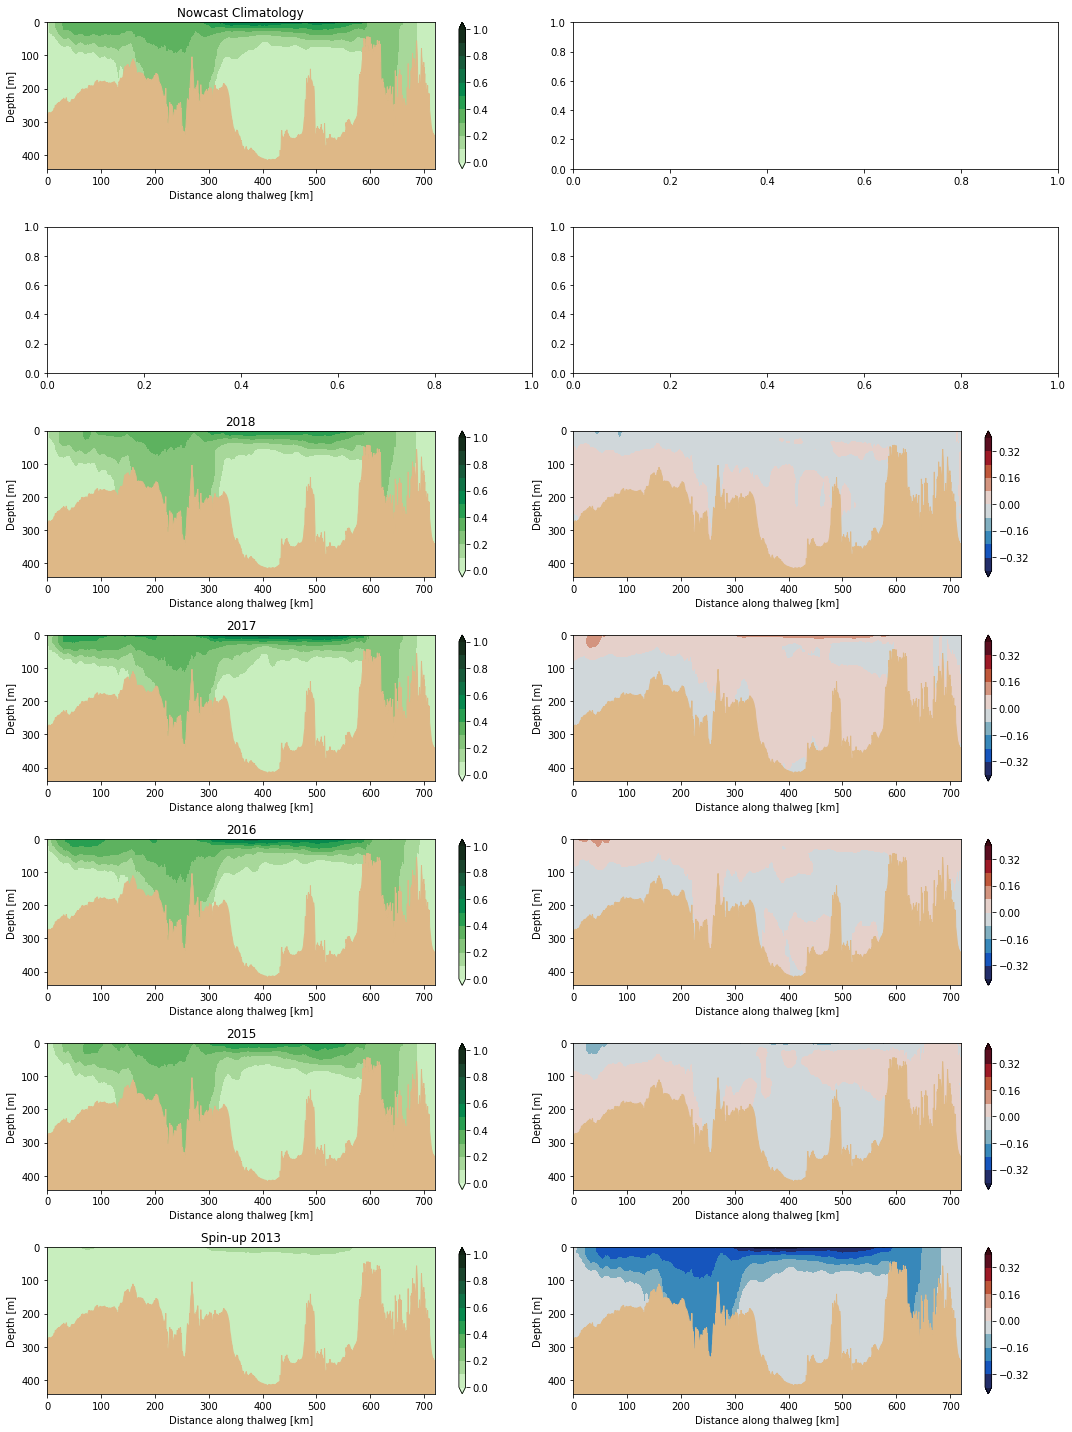

In [42]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.4
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

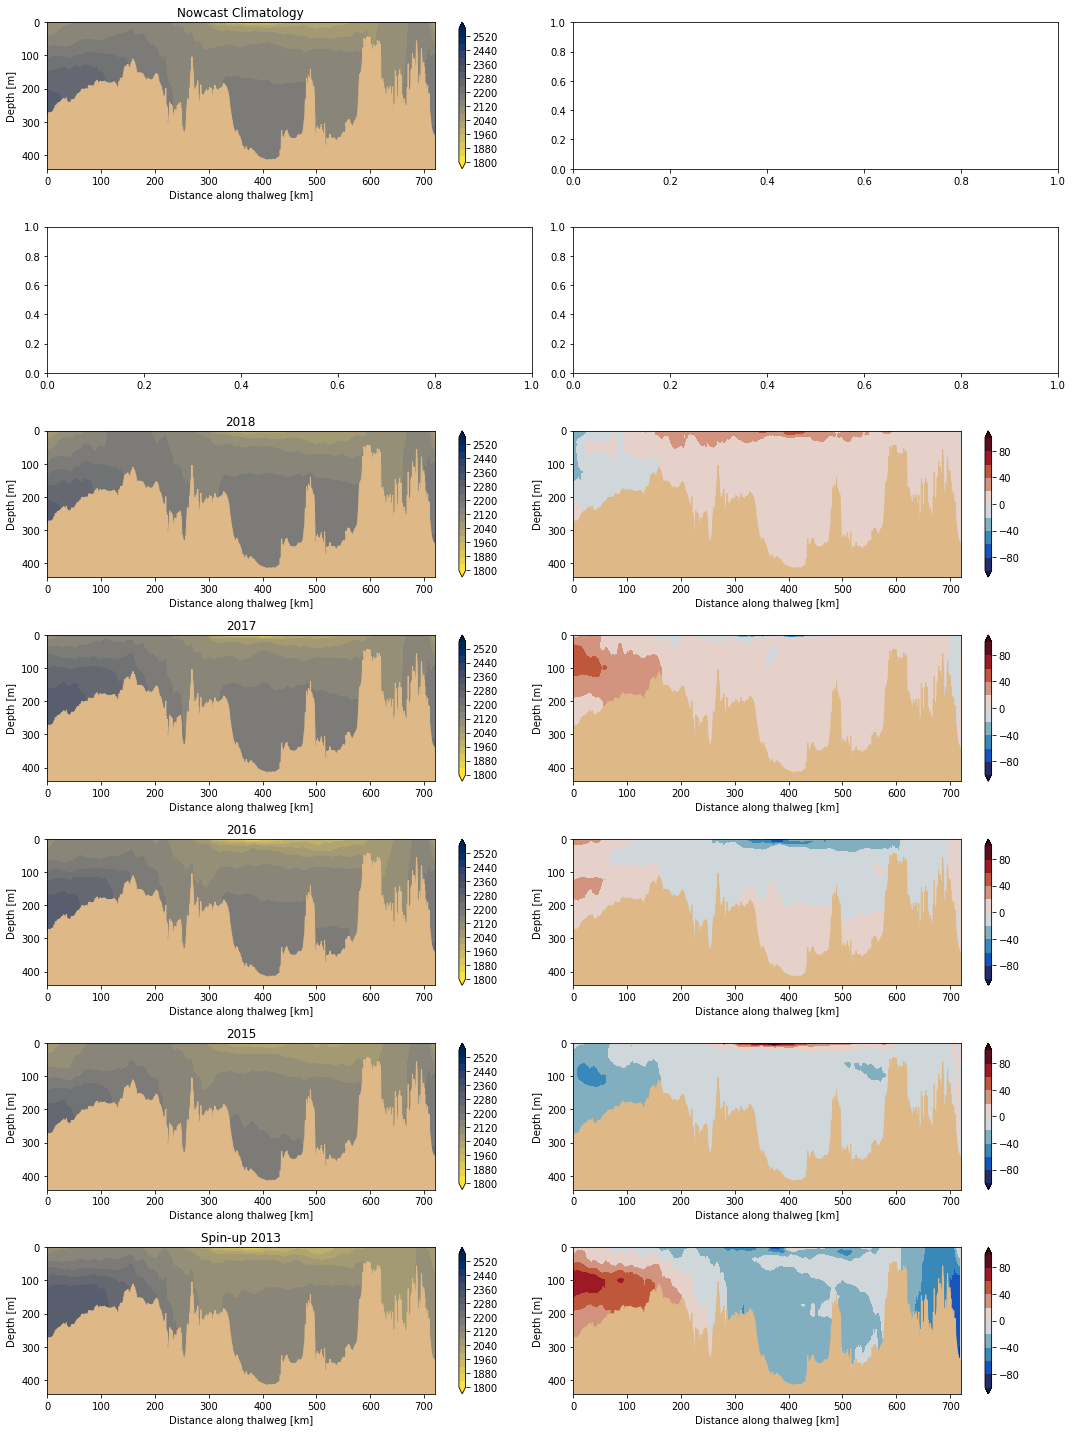

In [43]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 100
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

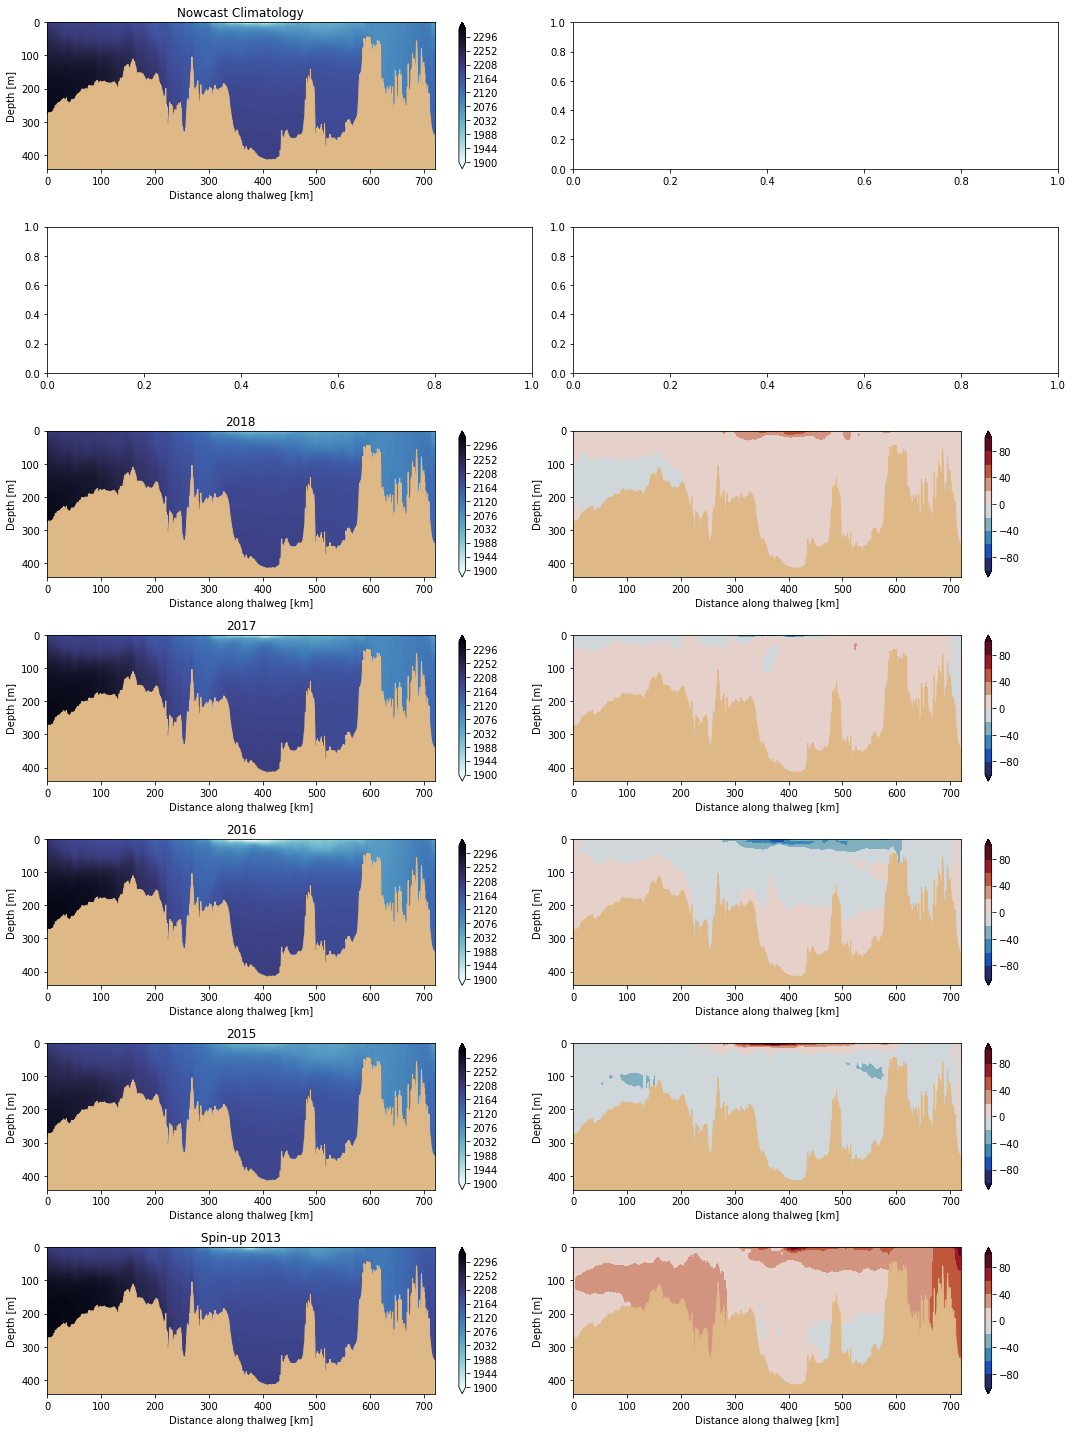

In [44]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cdiff = cm.balance
vmax = 1940
vmin = 1900
dvmax = 100
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

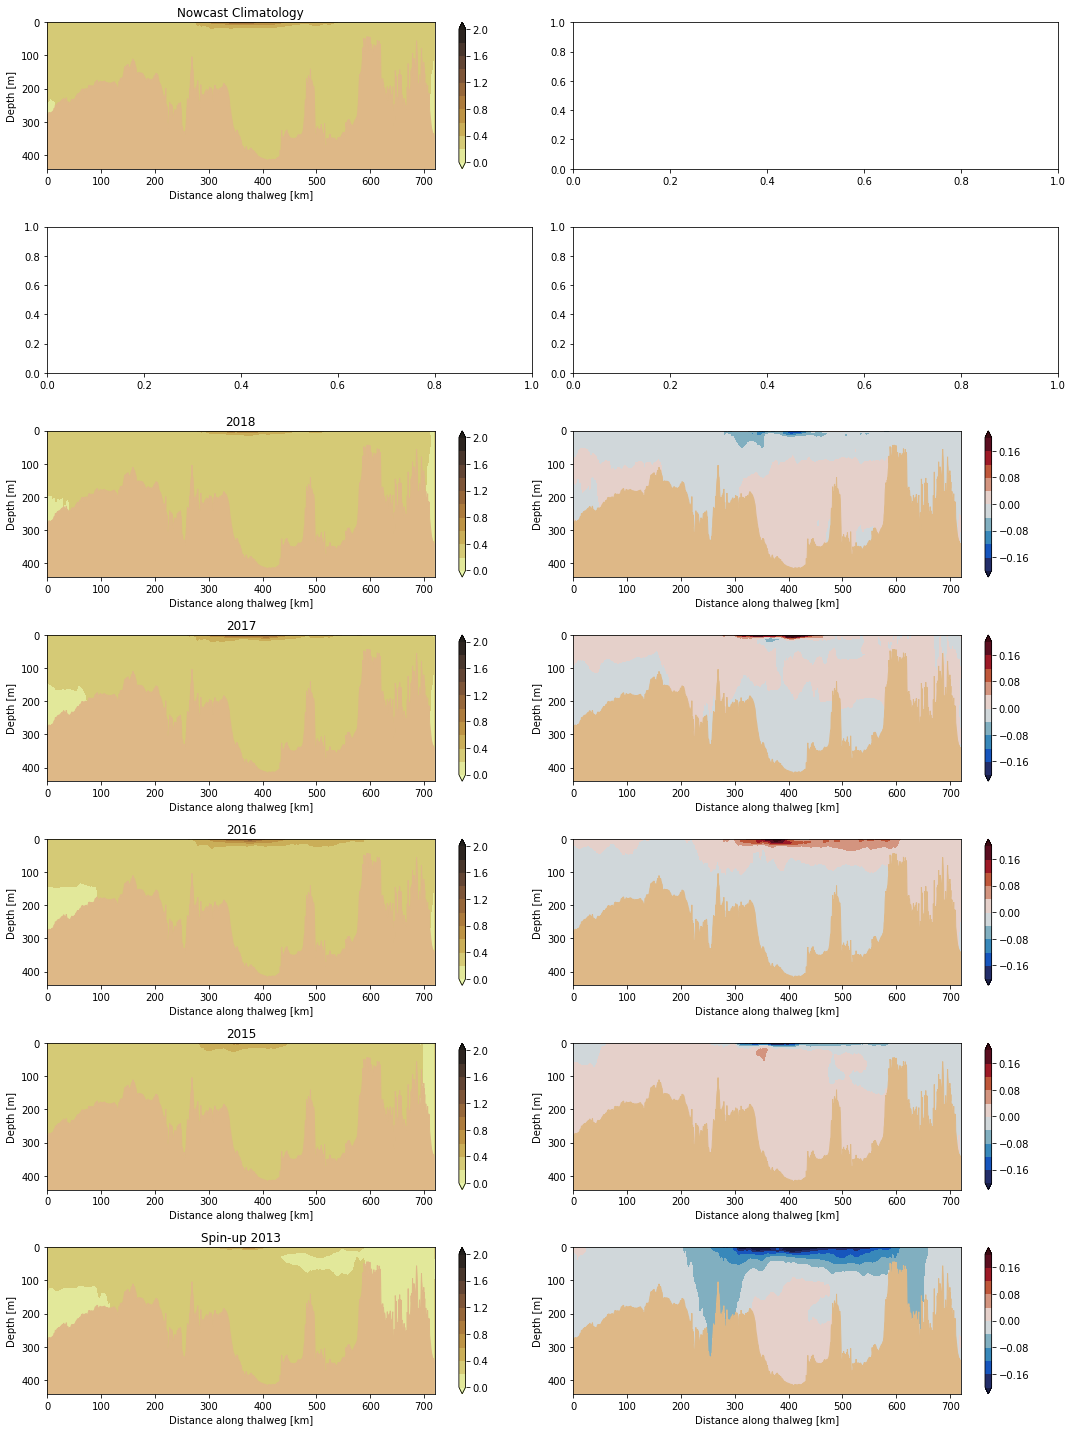

In [45]:
tracer = 'Fraser_tracer'
file = 'turb'
cmap = cm.turbid
cdiff = cm.balance
vmax = 2
vmin = 0
dvmax = 0.2
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
fig.savefig(tracer+'_'+month+'_thalweg.png')

In [46]:
stop

NameError: name 'stop' is not defined

# redo DIC/Alkalinity Plots

In [ ]:
my_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
            'jul', 'aug', 'sep', 'oct', 'nov']
my_imonths = ['01', '02','03', '04','05','06',
             '07','08','09','10','11']

In [ ]:
for month, imonth in zip(my_months, my_imonths):
    print (month, imonth)
    #1
    tracer = 'dissolved_inorganic_carbon'
    file = 'carp'
    cmap = 'cividis_r'
    cdiff = cm.balance
    vmax = 2300
    vmin = 1900
    dvmax = 100
    fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
    fig.savefig(tracer+'_'+month+'_surface.png')
    #2
    tracer = 'total_alkalinity'
    file = 'carp'
    cmap = cm.ice_r
    cmap.set_bad('#8b7765')
    cdiff = cm.balance
    vmax = 2300
    vmin = 1900
    dvmax = 100
    fig = surface_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
    fig.savefig(tracer+'_'+month+'_surface.png')
    # 3
    tracer = 'dissolved_inorganic_carbon'
    file = 'carp'
    cmap = 'cividis_r'
    cdiff = cm.balance
    vmax = 2200
    vmin = 1800
    dvmax = 100
    fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
    fig.savefig(tracer+'_'+month+'_thalweg.png')
    # 4
    tracer = 'total_alkalinity'
    file = 'carp'
    cmap = cm.ice_r
    cdiff = cm.balance
    vmax = 1940
    vmin = 1900
    dvmax = 100
    fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)
    fig.savefig(tracer+'_'+month+'_thalweg.png')